In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torchinfo import summary

from models.transLOB_v2 import TransLOB
from utils.preprocessing_v2 import create_windows, generate_labels, normalize_features, add_features
from utils.training import train, validate
from utils.loader import LOBDataset

%load_ext autoreload
%autoreload 2

/home/sc3791/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Downloading Data

In [3]:
destination = 'data/crypto/'
if not os.path.exists(destination) or len(os.listdir(destination)) == 0:
    path = kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")
    shutil.copytree(path, destination)

## Processing Data

In [4]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 32 # 32
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_10'
LABEL_ALPHA = 1e-5

LEARNING_RATE = 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 5e-5 # 1e-5

In [5]:
data_df = pd.read_csv(DATA_PATH, index_col=0)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030728 entries, 0 to 1030727
Columns: 155 entries, system_time to asks_market_notional_14
dtypes: float64(154), object(1)
memory usage: 1.2+ GB


In [6]:
data_df = data_df[:400000]#.copy()
data_df['system_time'] = pd.to_datetime(data_df['system_time'])
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-5.023557e-05,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2021-04-12 02:40:21.102749+00:00,59723.315,0.01,260.281395,15.528061,-8.371940e-08,-5.860358e-07,-4.160854e-05,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399996,2021-04-12 02:40:22.102749+00:00,59723.315,0.01,0.000000,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399997,2021-04-12 02:40:23.102749+00:00,59723.315,0.01,0.000000,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399998,2021-04-12 02:40:24.102749+00:00,59723.315,0.01,114.933946,0.000000,-8.371940e-08,-2.511582e-07,-5.860358e-07,-0.000042,-0.000051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [f"{side}_distance_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
notional_features = [f"{side}_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
cancel_notional_features = [f"{side}_cancel_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
limit_notional_features = [f"{side}_limit_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
market_notional_features = [f"{side}_market_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]

midpoint_delta_features = ['midpoint_delta']

In [8]:
data_df = data_df[meta_features + distance_features + notional_features + market_notional_features]
data_df = generate_labels(data_df, HORIZONS, alpha=LABEL_ALPHA)
data_df = add_features(data_df)
data_df = normalize_features(data_df)
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,y_10,y_20,y_30,y_50,y_100,midpoint_delta
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.0,0.0,0.0,0.0,1,2,2,2,2,0.0
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.0,0.0,0.0,0.0,1,2,2,2,2,0.0
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.0,0.0,0.0,0.0,1,2,2,2,2,0.0
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.0,0.0,0.0,0.0,1,2,2,2,2,0.0
5,2021-04-07 11:32:47.122161+00:00,56035.995,0.01,0.000000,0.000000,-0.000089,-0.000268,-0.050236,-0.245467,-0.287761,...,0.0,0.0,0.0,0.0,1,2,2,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2021-04-12 02:40:21.102749+00:00,59723.315,0.01,260.281395,15.528061,-0.000084,-0.000586,-0.041609,-0.041943,-0.050985,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0.0
399996,2021-04-12 02:40:22.102749+00:00,59723.315,0.01,0.000000,0.000000,-0.000084,-0.000251,-0.000586,-0.041943,-0.050985,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0.0
399997,2021-04-12 02:40:23.102749+00:00,59723.315,0.01,0.000000,0.000000,-0.000084,-0.000251,-0.000586,-0.041943,-0.050985,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0.0
399998,2021-04-12 02:40:24.102749+00:00,59723.315,0.01,114.933946,0.000000,-0.000084,-0.000251,-0.000586,-0.041943,-0.050985,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0.0


## EDA

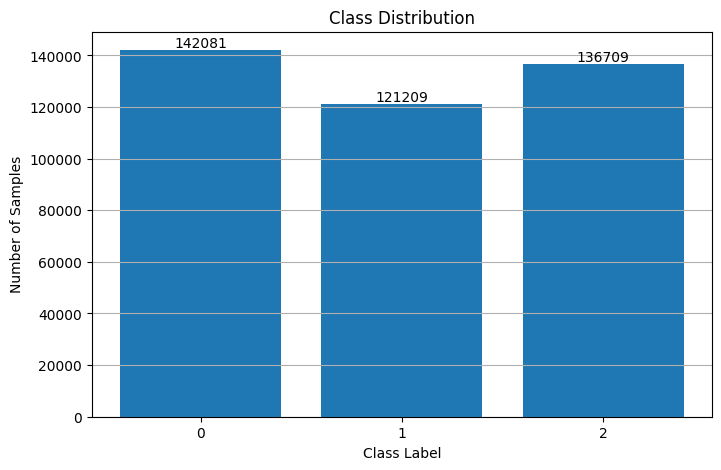

In [9]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

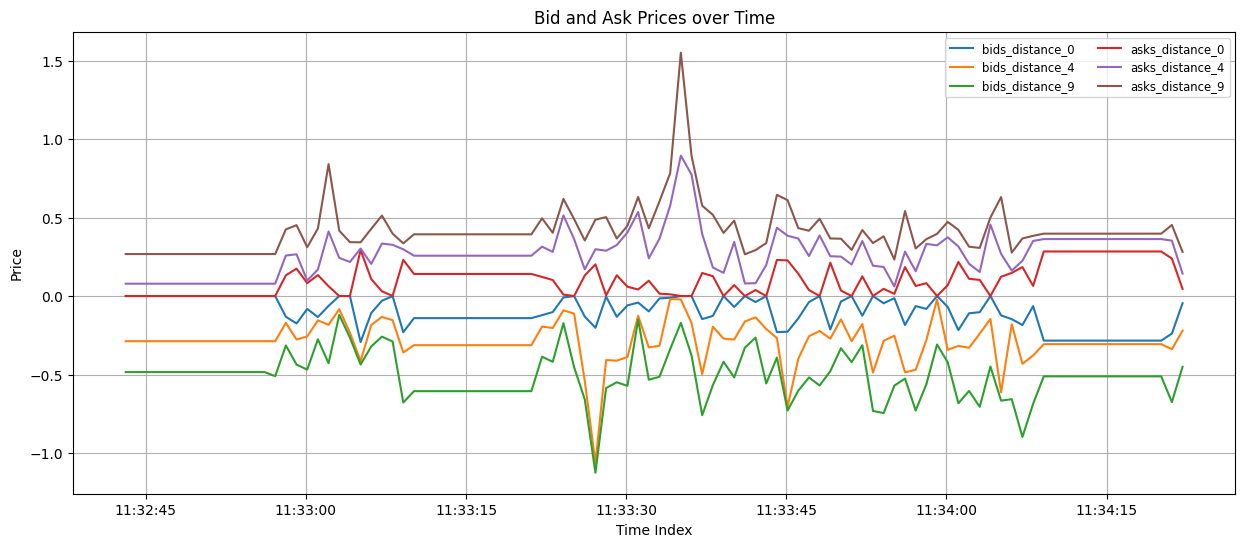

In [10]:
bid_price_cols = ['bids_distance_0','bids_distance_4','bids_distance_9']
ask_price_cols = ['asks_distance_0','asks_distance_4','asks_distance_9']

plot_range = 100

plt.figure(figsize=(15, 6))

# Plot bids
for col in bid_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='blue', alpha=0.5)

# Plot asks
for col in ask_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='red', alpha=0.5)

plt.title('Bid and Ask Prices over Time')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid()
plt.show()

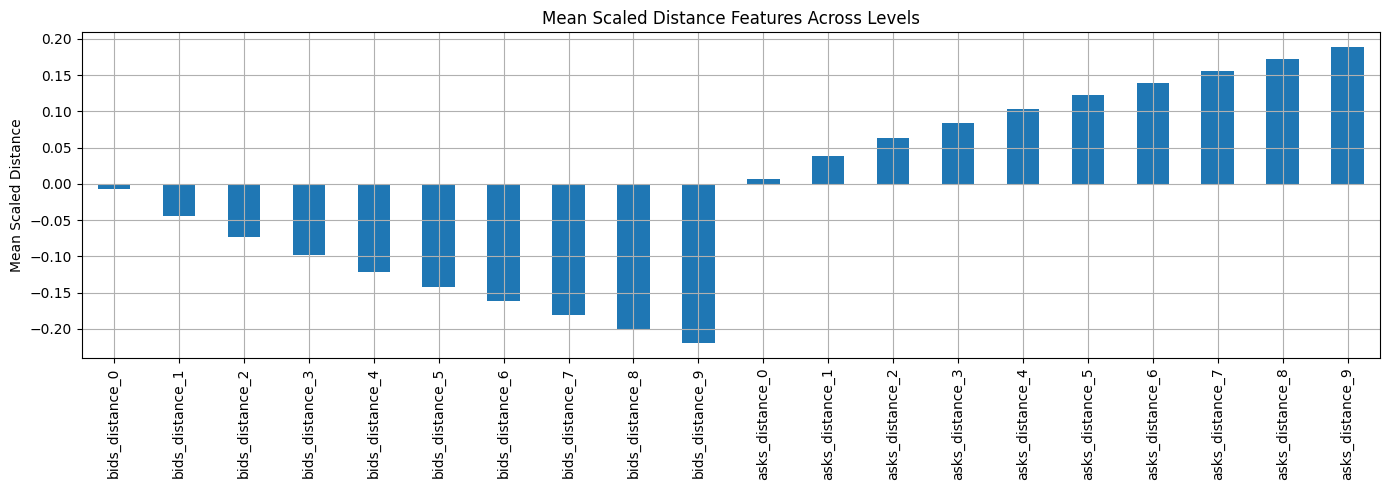

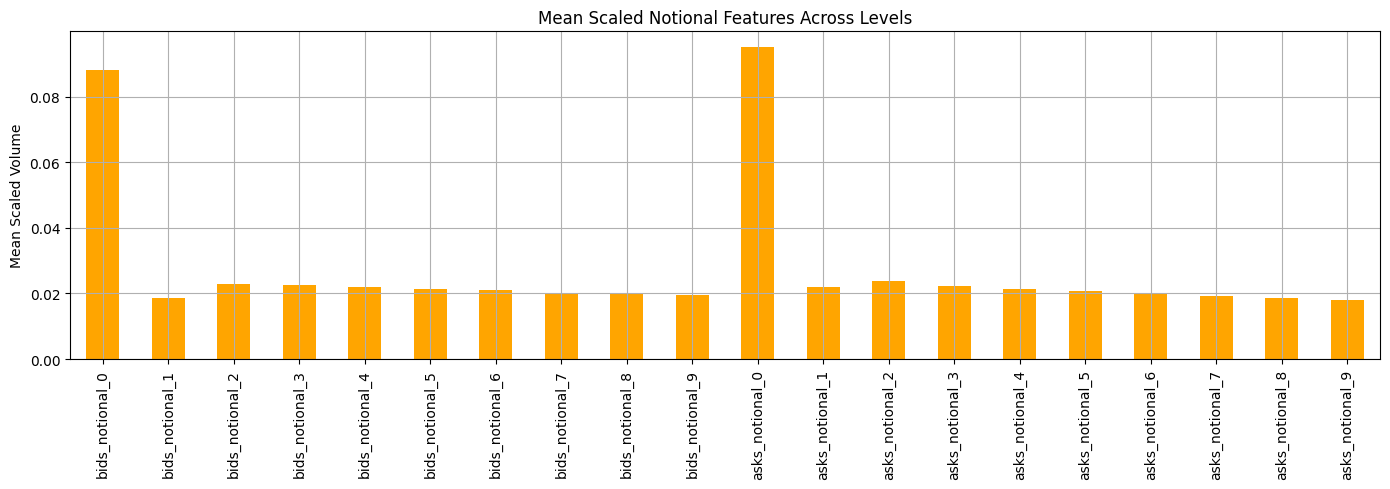

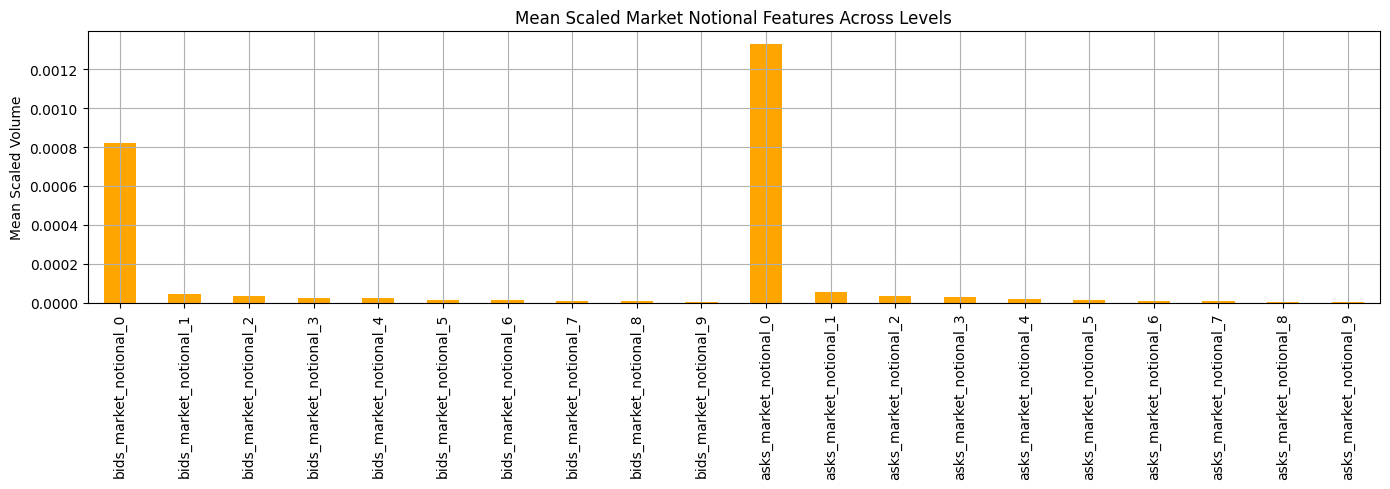

In [11]:
# Plot mean distance values across levels
plt.figure(figsize=(14, 5))
data_df[distance_features].mean().plot(kind='bar', title='Mean Scaled Distance Features Across Levels')
plt.ylabel('Mean Scaled Distance')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
data_df[notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
data_df[market_notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Market Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
feature_cols = [col for col in data_df.columns if col not in meta_features and not col.startswith('y_')]

X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((399999, 61), (399999,))

In [13]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(399899, 100, 61)

In [14]:
# distances = data_df[distance_features].melt(var_name="distance_level", value_name="distance_value")
# notionals = data_df[notional_features].melt(var_name="notional_level", value_name="notional_value")

# combined = pd.DataFrame({
#     "distance": distances["distance_value"],
#     "notional": notionals["notional_value"]
# })

# plt.figure(figsize=(14, 6))
# plt.scatter(combined["distance"], combined["notional"], alpha=0.3)
# plt.xlabel('Distance from Midprice')
# plt.ylabel('Notional Volume')
# plt.title('Price Distance vs Notional Volume')
# plt.grid(True)
# plt.show()

## TransLOB

In [15]:
train_size = int(0.8 * len(X_windows))

X_train, y_train = X_windows[:train_size], y_labels[:train_size]
X_val, y_val = X_windows[train_size:], y_labels[train_size:]

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, 
#     test_size=0.1, 
#     random_state=42, 
#     shuffle=True
# )

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
# print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (319919, 100, 61), (319919,)
Validation shape: (79980, 100, 61), (79980,)


In [16]:
train_dataset = LOBDataset(X_train, y_train)
val_dataset = LOBDataset(X_val, y_val)
# test_dataset = LOBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
model = TransLOB(
    num_features=len(feature_cols),
    num_classes=3,
    hidden_channels=14,
    d_model=64,
    num_heads=4,
    num_transformer_blocks=2
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(ADAM_B1, ADAM_B2), weight_decay=WEIGHT_DECAY)

summary(model, (1, 100, 61))

Layer (type:depth-idx)                   Output Shape              Param #
TransLOB                                 [1, 3]                    --
├─LOBFeatureExtractor: 1-1               [1, 100, 14]              --
│    └─Conv1d: 2-1                       [1, 14, 100]              1,722
│    └─Conv1d: 2-2                       [1, 14, 100]              406
│    └─Conv1d: 2-3                       [1, 14, 100]              406
│    └─Conv1d: 2-4                       [1, 14, 100]              406
│    └─Conv1d: 2-5                       [1, 14, 100]              406
├─LayerNorm: 1-2                         [1, 100, 14]              28
├─LOBPositionalEncoding: 1-3             [1, 100, 15]              --
├─Linear: 1-4                            [1, 100, 64]              1,024
├─LOBTransformerBlock: 1-5               [1, 100, 64]              --
│    └─MultiheadAttention: 2-6           [1, 100, 64]              16,640
│    └─LayerNorm: 2-7                    [1, 100, 64]              128


In [18]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 30
best_val_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    # val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './outputs/transLOB/best_model.pth')
        print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")

[Batch 0/9998] Train Loss: 1.0899 | Train Accuracy: 0.3750
[Batch 500/9998] Train Loss: 1.1056 | Train Accuracy: 0.2812
[Batch 1000/9998] Train Loss: 1.0309 | Train Accuracy: 0.4062
[Batch 1500/9998] Train Loss: 1.0201 | Train Accuracy: 0.4062
[Batch 2000/9998] Train Loss: 1.0387 | Train Accuracy: 0.4062
[Batch 2500/9998] Train Loss: 1.0623 | Train Accuracy: 0.4062
[Batch 3000/9998] Train Loss: 1.0577 | Train Accuracy: 0.4375
[Batch 3500/9998] Train Loss: 1.0918 | Train Accuracy: 0.3750
[Batch 4000/9998] Train Loss: 0.9162 | Train Accuracy: 0.5625
[Batch 4500/9998] Train Loss: 1.1169 | Train Accuracy: 0.3438
[Batch 5000/9998] Train Loss: 1.0250 | Train Accuracy: 0.3750
[Batch 5500/9998] Train Loss: 1.0149 | Train Accuracy: 0.5000
[Batch 6000/9998] Train Loss: 1.0162 | Train Accuracy: 0.3750
[Batch 6500/9998] Train Loss: 1.1071 | Train Accuracy: 0.4062
[Batch 7000/9998] Train Loss: 1.1354 | Train Accuracy: 0.4375
[Batch 7500/9998] Train Loss: 1.1621 | Train Accuracy: 0.3125
[Batch 8000/

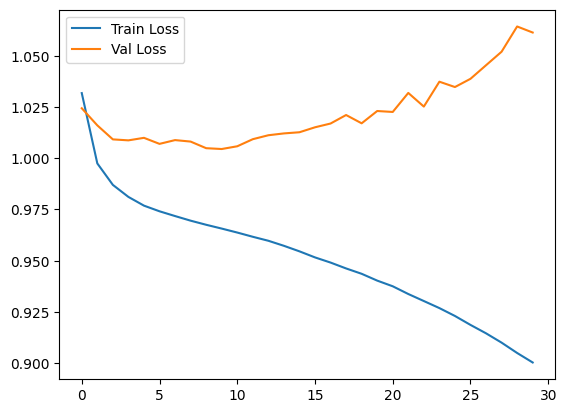

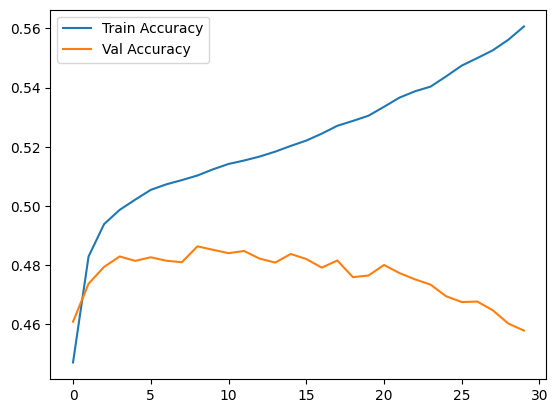

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

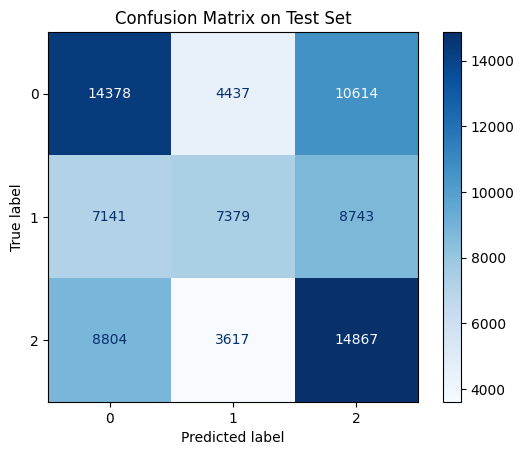

Test Accuracy: 0.4579
Test Precision (macro): 0.4622
Test Recall (macro): 0.4502
Test F1 Score (macro): 0.4487


In [20]:
model.eval()

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        _, y_pred = outputs.max(1)

        all_y_true.append(y_batch.cpu().numpy())
        all_y_pred.append(y_pred.cpu().numpy())

all_y_true = np.concatenate(all_y_true)
all_y_pred = np.concatenate(all_y_pred)

cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()

accuracy = accuracy_score(all_y_true, all_y_pred)
precision = precision_score(all_y_true, all_y_pred, average='macro')
recall = recall_score(all_y_true, all_y_pred, average='macro')
f1 = f1_score(all_y_true, all_y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision (macro): {precision:.4f}")
print(f"Test Recall (macro): {recall:.4f}")
print(f"Test F1 Score (macro): {f1:.4f}")